<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/oscar-wilde/el-retrato-de-dorian-gray/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' el artista es creador de belleza. revelar el arte y ocultar al artista es la meta del arte. el crítico es quien puede traducir de manera distinta o con nuevos \r\nmateriales su impresión de la belleza. la forma más elevada de la \r\ncrítica, y también la más rastrera, es una modalidad de autobiografía. quienes descubren significados ruines en cosas hermosas están \r\ncorrompidos sin ser elegantes, lo que es un defecto. quienes encuentran \r\nsignificados bellos en cosas hermosas son espíritus cultivados. para \r\nellos hay esperanza. son los elegidos, y en su caso las cosas hermosas sólo significan belleza. no existen libros morales o inmorales. los libros están bien o mal escritos. eso es todo. la aversión del siglo por el realismo es la rabia de calibán al verse la cara en el espejo. la aversión del siglo por el romanticismo es la rabia de calibán al no verse la cara en un espejo. la vida moral del hombre forma parte de los temas del artista, pero \r\nla moralidad del arte consiste

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

65

In [9]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [10]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [11]:
tokenized_text[:10]

[57, 40, 2, 57, 1, 35, 45, 6, 25, 45]

### Organizando y estructurando el dataset

In [12]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [13]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [14]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [15]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [16]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
X.shape

(419061, 100)

In [18]:
X[0,:10]

array([57, 40,  2, 57,  1, 35, 45,  6, 25, 45])

In [19]:
y[0,:10]

array([40,  2, 57,  1, 35, 45,  6, 25, 45,  1])

In [20]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [21]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [22]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 65)         0         
 ibuted)                                                         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 200)         53200     
                                                                 
 dense (Dense)               (None, None, 65)          13065     
                                                                 
Total params: 66,265
Trainable params: 66,265
Non-trainable params: 0
_________________________________________________________________



### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [25]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5,model_name='my_model'):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.model_name = model_name
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0, batch_size=2048)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [26]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5,'my_model_Elman')], batch_size=2048)

Epoch 1/20
205/205 [==============================] - ETA: 0s - loss: 2.2680
 mean perplexity: 8.074709427003222 

INFO:tensorflow:Assets written to: my_model_Elman\assets
Saved new model!
205/205 [==============================] - 40s 193ms/step - loss: 2.2680
Epoch 2/20
205/205 [==============================] - ETA: 0s - loss: 2.1381
 mean perplexity: 7.422574611110533 

INFO:tensorflow:Assets written to: my_model_Elman\assets
Saved new model!
205/205 [==============================] - 38s 184ms/step - loss: 2.1381
Epoch 3/20
205/205 [==============================] - ETA: 0s - loss: 2.0573
 mean perplexity: 6.772387428075349 

INFO:tensorflow:Assets written to: my_model_Elman\assets
Saved new model!
205/205 [==============================] - 38s 184ms/step - loss: 2.0573
Epoch 4/20
205/205 [==============================] - ETA: 0s - loss: 1.9875
 mean perplexity: 6.325850754296115 

INFO:tensorflow:Assets written to: my_model_Elman\assets
Saved new model!
205/205 [================

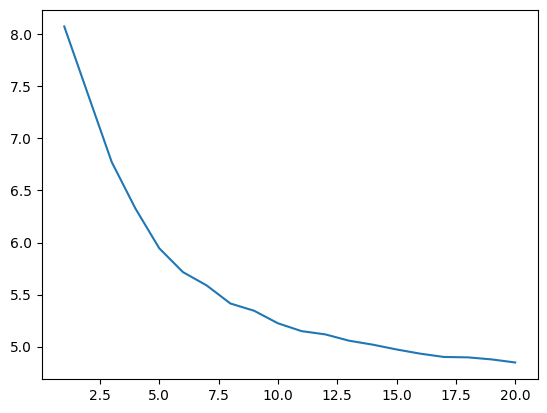

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

###Usando LSTM

In [28]:
model1 = Sequential()

model1.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model1.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model1.add(Dense(vocab_size, activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, None, 65)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, None, 200)         212800    
                                                                 
 dense_1 (Dense)             (None, None, 65)          13065     
                                                                 
Total params: 225,865
Trainable params: 225,865
Non-trainable params: 0
_________________________________________________________________


In [29]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model1.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5,'my_model_LSTM')], batch_size=2048)

Epoch 1/20
205/205 [==============================] - ETA: 0s - loss: 2.8192
 mean perplexity: 11.402097999109738 

INFO:tensorflow:Assets written to: my_model_LSTM\assets
Saved new model!
205/205 [==============================] - 131s 625ms/step - loss: 2.8192
Epoch 2/20
205/205 [==============================] - ETA: 0s - loss: 2.3162
 mean perplexity: 8.883076891465363 

INFO:tensorflow:Assets written to: my_model_LSTM\assets
Saved new model!
205/205 [==============================] - 126s 615ms/step - loss: 2.3162
Epoch 3/20
205/205 [==============================] - ETA: 0s - loss: 2.1526
 mean perplexity: 7.772527012993605 

INFO:tensorflow:Assets written to: my_model_LSTM\assets
Saved new model!
205/205 [==============================] - 127s 617ms/step - loss: 2.1526
Epoch 4/20
205/205 [==============================] - ETA: 0s - loss: 2.0411
 mean perplexity: 7.117497972634929 

INFO:tensorflow:Assets written to: my_model_LSTM\assets
Saved new model!
205/205 [================

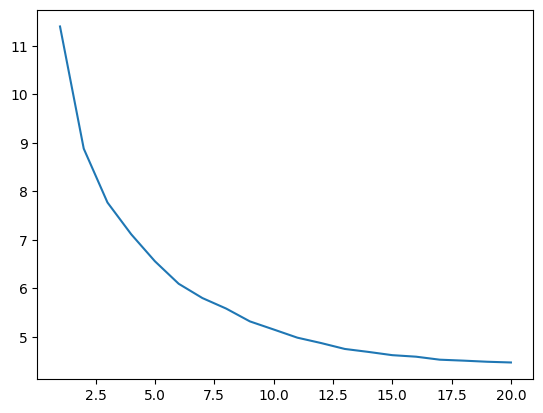

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

### Usando GRU

In [31]:
model2 = Sequential()

model2.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model2.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model2.add(Dense(vocab_size, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, None, 65)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, None, 200)         160200    
                                                                 
 dense_2 (Dense)             (None, None, 65)          13065     
                                                                 
Total params: 173,265
Trainable params: 173,265
Non-trainable params: 0
_________________________________________________________________


In [32]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5,'my_model_GRU')], batch_size=2048)

Epoch 1/20
205/205 [==============================] - ETA: 0s - loss: 2.6317
 mean perplexity: 9.201618234409427 

INFO:tensorflow:Assets written to: my_model_GRU\assets
Saved new model!
205/205 [==============================] - 125s 600ms/step - loss: 2.6317
Epoch 2/20
205/205 [==============================] - ETA: 0s - loss: 2.1642
 mean perplexity: 7.570274866288409 

INFO:tensorflow:Assets written to: my_model_GRU\assets
Saved new model!
205/205 [==============================] - 118s 576ms/step - loss: 2.1642
Epoch 3/20
205/205 [==============================] - ETA: 0s - loss: 1.9987
 mean perplexity: 6.707766900286934 

INFO:tensorflow:Assets written to: my_model_GRU\assets
Saved new model!
205/205 [==============================] - 119s 582ms/step - loss: 1.9987
Epoch 4/20
205/205 [==============================] - ETA: 0s - loss: 1.8734
 mean perplexity: 6.00923620620439 

INFO:tensorflow:Assets written to: my_model_GRU\assets
Saved new model!
205/205 [======================

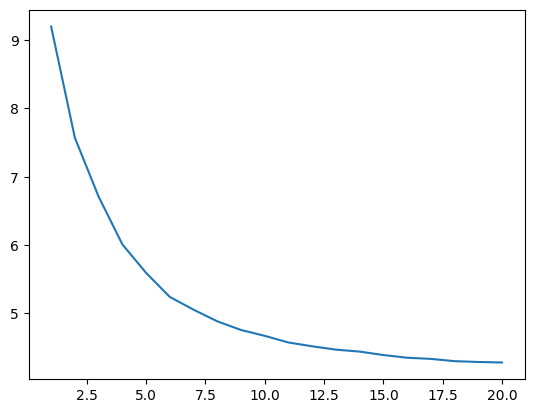

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [38]:
model3 = Sequential()

model3.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model3.add(GRU(40, return_sequences=True,))
model3.add(GRU(40, return_sequences=True,))
model3.add(GRU(40, return_sequences=True,))
model3.add(GRU(40, return_sequences=True,))
model3.add(GRU(40, return_sequences=True,))
model3.add(Dense(vocab_size, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, None, 65)         0         
 tributed)                                                       
                                                                 
 gru_11 (GRU)                (None, None, 40)          12840     
                                                                 
 gru_12 (GRU)                (None, None, 40)          9840      
                                                                 
 gru_13 (GRU)                (None, None, 40)          9840      
                                                                 
 gru_14 (GRU)                (None, None, 40)          9840      
                                                                 
 gru_15 (GRU)                (None, None, 40)          9840      
                                                      

In [39]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model3.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5,'my_model_GRU2')], batch_size=2048)

Epoch 1/20
205/205 [==============================] - ETA: 0s - loss: 3.0670
 mean perplexity: 18.579493227299245 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 45s 191ms/step - loss: 3.0670
Epoch 2/20
205/205 [==============================] - ETA: 0s - loss: 2.5789
 mean perplexity: 11.30130107786873 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 37s 180ms/step - loss: 2.5789
Epoch 3/20
205/205 [==============================] - ETA: 0s - loss: 2.3482
 mean perplexity: 10.055080524027218 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 186ms/step - loss: 2.3482
Epoch 4/20
205/205 [==============================] - ETA: 0s - loss: 2.2511
 mean perplexity: 9.305491774576717 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 186ms/step - loss: 2.2511
Epoch 5/20
205/205 [==============================] - ETA: 0s - loss: 2.1847
 mean perplexity: 8.75343361109786 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 185ms/step - loss: 2.1847
Epoch 6/20
205/205 [==============================] - ETA: 0s - loss: 2.1294
 mean perplexity: 8.382923071071634 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 37s 180ms/step - loss: 2.1294
Epoch 7/20
205/205 [==============================] - ETA: 0s - loss: 2.0827
 mean perplexity: 8.27095781697519 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 185ms/step - loss: 2.0827
Epoch 8/20
205/205 [==============================] - ETA: 0s - loss: 2.0449
 mean perplexity: 7.954799470536818 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 37s 181ms/step - loss: 2.0449
Epoch 9/20
205/205 [==============================] - ETA: 0s - loss: 2.0128
 mean perplexity: 7.77611059594365 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 37s 182ms/step - loss: 2.0128
Epoch 10/20
205/205 [==============================] - ETA: 0s - loss: 1.9833
 mean perplexity: 7.56864448488455 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 37s 179ms/step - loss: 1.9833
Epoch 11/20
205/205 [==============================] - ETA: 0s - loss: 1.9559
 mean perplexity: 7.416958323199366 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 188ms/step - loss: 1.9559
Epoch 12/20
205/205 [==============================] - ETA: 0s - loss: 1.9293
 mean perplexity: 7.292804186260267 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 184ms/step - loss: 1.9293
Epoch 13/20
205/205 [==============================] - ETA: 0s - loss: 1.9027
 mean perplexity: 7.185393539563165 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 37s 182ms/step - loss: 1.9027
Epoch 14/20
205/205 [==============================] - ETA: 0s - loss: 1.8772
 mean perplexity: 6.897955787637963 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 39s 189ms/step - loss: 1.8772
Epoch 15/20
205/205 [==============================] - ETA: 0s - loss: 1.8527
 mean perplexity: 6.766035193904627 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 185ms/step - loss: 1.8527
Epoch 16/20
205/205 [==============================] - ETA: 0s - loss: 1.8301
 mean perplexity: 6.692481020115681 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 185ms/step - loss: 1.8301
Epoch 17/20
205/205 [==============================] - ETA: 0s - loss: 1.8099
 mean perplexity: 6.50414745553233 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 39s 190ms/step - loss: 1.8099
Epoch 18/20
205/205 [==============================] - ETA: 0s - loss: 1.7908
 mean perplexity: 6.437474122566175 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 36s 176ms/step - loss: 1.7908
Epoch 19/20
205/205 [==============================] - ETA: 0s - loss: 1.7727
 mean perplexity: 6.40163631757194 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 38s 184ms/step - loss: 1.7727
Epoch 20/20
205/205 [==============================] - ETA: 0s - loss: 1.7564
 mean perplexity: 6.231876692497312 



INFO:tensorflow:Assets written to: my_model_GRU2\assets


INFO:tensorflow:Assets written to: my_model_GRU2\assets


Saved new model!
205/205 [==============================] - 37s 181ms/step - loss: 1.7564


Los resultados despues de entrar a cada modelo por solamente 20 epocas.
Cabe aclarar que en el caso de GRU5 se eligio utilizar dado que las topologias GRU y LSTM se asemejan a la idea de las redes residuales, que utilizan skip connections para evitar que se degrade el gradiente. Por lo tanto serian especialmente utiles en redes con muchas capas. Y como las redes residuales, permiten entrenar mucho mas. Sin embargo al solo entrenar 20 epocas, no le podemos sacar el provecho.

| Modelo       | Parameters | Perplexity |
|--------------|------------|------------|
| Elman        | 66.265     | 4.85       |
| LSTM         | 225.865    | 4.47       |
| GRU          | 173.265    | 4.28       |
| GRU, 5 CAPAS | 54.865     | 6.23       |


### Predicción del próximo caracter

In [41]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlserver 1.3.5 requires fastapi!=0.89.0,<=0.89.1,>=0.88.0, but you have fastapi 0.111.1 which is incompatible.


In [42]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

c:\Users\Gonzalo\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 38ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [44]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [47]:
input_text='el retrato'


print(generate_seq(model, input_text, max_length=max_context_size, n_words=30)) # Elman
print(generate_seq(model1, input_text, max_length=max_context_size, n_words=30)) #LSTM
print(generate_seq(model2, input_text, max_length=max_context_size, n_words=30)) # GRU
print(generate_seq(model3, input_text, max_length=max_context_size, n_words=30)) # GRU5


el retrato de la puerta de la puerta de 
el retrato de la mano en el pecado en la
el retrato de la mesa, y la mesa y la pu
el retrato de la marande de la marande d


###  Beam search y muestreo aleatorio

In [50]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [48]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [55]:
# predicción con beam search
print('--- Elman ---')
beam= beam_search(model,num_beams=10,num_words=50,input="dorian gray estaba");
for item in range(10):
    print(decode(beam[item]))
print('--- LSTM ---')
beam= beam_search(model1,num_beams=10,num_words=50,input="dorian gray estaba");
for item in range(10):
    print(decode(beam[item]))
print('--- GRU ---')
beam= beam_search(model2,num_beams=10,num_words=50,input="dorian gray estaba");
for item in range(10):
    print(decode(beam[item]))
print('--- GRU5 ---')
beam= beam_search(model3,num_beams=10,num_words=50,input="dorian gray estaba");
for item in range(10):
    print(decode(beam[item]))


--- Elman ---
dorian gray estaba en el mundo en el mundo en el mundo en el mundo e
dorian gray estaba en el mundo en el mundo en el mundo en la cabeza 
dorian gray estaba en el mundo en el mundo en el retrato de la vida 
dorian gray estaba en el mundo en el mundo en el mundo en el mundo. 
dorian gray estaba en el mundo en el mundo en el mundo en el pintor 
dorian gray estaba en el mundo en el mundo en el mundo en el mundo, 
dorian gray estaba en el mundo en el mundo en el mundo en la cabeza.
dorian gray estaba en el mundo en el mundo en el mundo en el mundo a
dorian gray estaba en el mundo en el mundo en el mundo en el mundo l
dorian gray estaba en el mundo en el mundo en el mundo en el mundo s
--- LSTM ---
dorian gray estaba en el cuadro de las mujeres que se había encontra
dorian gray estaba en el cuadro de las mujeres que había algo en el 
dorian gray estaba en el cuadro de las mujeres que se había sido una
dorian gray estaba en el cuadro de las mujeres que había algo en la 
dorian 

In [57]:
# predicción con beam search con temperatura 10
print('--- Elman ---')
beam= beam_search(model,num_beams=10,num_words=50,input="dorian gray estaba",temp=10);
for item in range(10):
    print(decode(beam[item]))
print('--- LSTM ---')
beam= beam_search(model1,num_beams=10,num_words=50,input="dorian gray estaba",temp=10);
for item in range(10):
    print(decode(beam[item]))
print('--- GRU ---')
beam= beam_search(model2,num_beams=10,num_words=50,input="dorian gray estaba",temp=10);
for item in range(10):
    print(decode(beam[item]))
print('--- GRU5 ---')
beam= beam_search(model3,num_beams=10,num_words=50,input="dorian gray estaba",temp=10);
for item in range(10):
    print(decode(beam[item]))

--- Elman ---
dorian gray estaba en el mundo en el mundo en el mundo en el mundo e
dorian gray estaba en el mundo en el mundo en el mundo en la cabeza 
dorian gray estaba en el mundo en el mundo en el retrato de la vida 
dorian gray estaba en el mundo en el mundo en el mundo en el mundo. 
dorian gray estaba en el mundo en el mundo en el mundo en el pintor 
dorian gray estaba en el mundo en el mundo en el mundo en el mundo, 
dorian gray estaba en el mundo en el mundo en el mundo en la cabeza.
dorian gray estaba en el mundo en el mundo en el mundo en el mundo a
dorian gray estaba en el mundo en el mundo en el mundo en el mundo l
dorian gray estaba en el mundo en el mundo en el mundo en el mundo s
--- LSTM ---
dorian gray estaba en el cuadro de las mujeres que se había encontra
dorian gray estaba en el cuadro de las mujeres que había algo en el 
dorian gray estaba en el cuadro de las mujeres que se había sido una
dorian gray estaba en el cuadro de las mujeres que había algo en la 
dorian 

A ojo desnudo las oraciones mas humanas vienen de LSTM Y GRU que son los dos modelos de minima perplexity.

Para verificar y explorar un poco mas, propongo entrenar 20 epocas mas el mejor modelo, GRU

In [61]:
#Entrenemos GRU POR 20 epocas mas! (o hasta el early stopping)
history_ppl = []
hist = model2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,5,'my_model_GRU')], batch_size=2048)

Epoch 1/20
205/205 [==============================] - ETA: 0s - loss: 1.3832
 mean perplexity: 4.258897235967298 

INFO:tensorflow:Assets written to: my_model_GRU\assets


INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 121s 591ms/step - loss: 1.3832
Epoch 2/20
205/205 [==============================] - ETA: 0s - loss: 1.3784
 mean perplexity: 4.233474987545185 

INFO:tensorflow:Assets written to: my_model_GRU\assets


INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 124s 604ms/step - loss: 1.3784
Epoch 3/20
205/205 [==============================] - ETA: 0s - loss: 1.3739
 mean perplexity: 4.2340882880780395 

205/205 [==============================] - 117s 572ms/step - loss: 1.3739
Epoch 4/20
205/205 [==============================] - ETA: 0s - loss: 1.3700
 mean perplexity: 4.234792194326168 

205/205 [==============================] - 115s 562ms/step - loss: 1.3700
Epoch 5/20
205/205 [==============================] - ETA: 0s - loss: 1.3662
 mean perplexity: 4.227513137912837 

INFO:tensorflow:Assets written to: my_model_GRU\assets


INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 120s 586ms/step - loss: 1.3662
Epoch 6/20
205/205 [==============================] - ETA: 0s - loss: 1.3627
 mean perplexity: 4.215819880061064 

INFO:tensorflow:Assets written to: my_model_GRU\assets


INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 118s 574ms/step - loss: 1.3627
Epoch 7/20
205/205 [==============================] - ETA: 0s - loss: 1.3595
 mean perplexity: 4.201654175042858 

INFO:tensorflow:Assets written to: my_model_GRU\assets


INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 117s 571ms/step - loss: 1.3595
Epoch 8/20
205/205 [==============================] - ETA: 0s - loss: 1.3563
 mean perplexity: 4.211527819363268 

205/205 [==============================] - 116s 565ms/step - loss: 1.3563
Epoch 9/20
205/205 [==============================] - ETA: 0s - loss: 1.3535
 mean perplexity: 4.19811999954962 

INFO:tensorflow:Assets written to: my_model_GRU\assets


INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 117s 571ms/step - loss: 1.3535
Epoch 10/20
205/205 [==============================] - ETA: 0s - loss: 1.3509
 mean perplexity: 4.182627813236662 

INFO:tensorflow:Assets written to: my_model_GRU\assets


INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 120s 584ms/step - loss: 1.3509
Epoch 11/20
205/205 [==============================] - ETA: 0s - loss: 1.3483
 mean perplexity: 4.195216977082096 

205/205 [==============================] - 117s 571ms/step - loss: 1.3483
Epoch 12/20
205/205 [==============================] - ETA: 0s - loss: 1.3459
 mean perplexity: 4.1753532335427925 

INFO:tensorflow:Assets written to: my_model_GRU\assets


INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 118s 578ms/step - loss: 1.3459
Epoch 13/20
205/205 [==============================] - ETA: 0s - loss: 1.3438
 mean perplexity: 4.18966756654183 

205/205 [==============================] - 115s 561ms/step - loss: 1.3438
Epoch 14/20
205/205 [==============================] - ETA: 0s - loss: 1.3417
 mean perplexity: 4.191606138060005 

205/205 [==============================] - 115s 562ms/step - loss: 1.3417
Epoch 15/20
205/205 [==============================] - ETA: 0s - loss: 1.3396
 mean perplexity: 4.18762665598782 

205/205 [==============================] - 114s 557ms/step - loss: 1.3396
Epoch 16/20
205/205 [==============================] - ETA: 0s - loss: 1.3376
 mean perplexity: 4.177427859228957 

205/205 [==============================] - 119s 583ms/step - loss: 1.3376
Epoch 17/20
205/205 [==============================] - ETA: 0s - loss: 1.3356
 mean perplexity: 4.17243857544966 

INFO:tensorflow:Assets written to: m

INFO:tensorflow:Assets written to: my_model_GRU\assets


Saved new model!
205/205 [==============================] - 117s 571ms/step - loss: 1.3356
Epoch 18/20
205/205 [==============================] - ETA: 0s - loss: 1.3340
 mean perplexity: 4.209343747903034 

205/205 [==============================] - 120s 583ms/step - loss: 1.3340
Epoch 19/20
205/205 [==============================] - ETA: 0s - loss: 1.3322
 mean perplexity: 4.191259932981212 

205/205 [==============================] - 116s 565ms/step - loss: 1.3322
Epoch 20/20
205/205 [==============================] - ETA: 0s - loss: 1.3307
 mean perplexity: 4.216023009831537 

205/205 [==============================] - 116s 565ms/step - loss: 1.3307


In [62]:
model2 = keras.models.load_model('my_model_GRU')

Cargamos el mejor modelo y generamos 5 textos para ver que tan humano es!

In [67]:
print('--- GRU ---')
beam= beam_search(model2,num_beams=10,num_words=50,input="dorian gray es ",temp=10);
for item in range(10):
    print(decode(beam[item]))

--- GRU ---
dorian gray es lo que había encontrado por la cabeza de las cosas
dorian gray es lo que había encontrado por la cabeza de las mujer
dorian gray es lo que había encontrado por la cabeza de las manos
dorian gray es lo que había encontrado con las mujeres de los ojo
dorian gray es lo que había encontrado con las mujeres de las cos
dorian gray es lo que había encontrado con las mujeres de las man
dorian gray es lo que había encontrado con las mujeres de las muj
dorian gray es lo que había encontrado con las mujeres de las 
c
dorian gray es lo que había encontrado con las mujeres de las 
p
dorian gray es lo que había encontrado con las mujeres de las pal


No es excelente, pero para ser un modelo tan secillo, entrenado por una hora, es bastante bueno.